In [195]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from math import comb
import math

In [196]:
num_anchors = 288 #Number of anchors around the circle
line_darkness = 0.3  #Brightness of the center of each line
img_path = "../data/test.png"

In [197]:
def preprocess_image(image_path: str):
    """Returns a 2D numpy array with a greyscale, square image
    Args:
        image_path: Path to the image file
    Returns:
        img: The numpy 2D array of the image
        new_center: The center of the image
        radius: The radius of the image
    """
    # Load the image in grayscale
    img = Image.open(image_path).convert("L")

    # Normalize the image to [0, 1] and invert so that 1 is dark and 0 is bright
    img = 1 - np.array(img) / 255.0

    # Transpose the image to switch to (x, y) format
    img = img.T

    # Determine the center and radius
    width, height = img.shape
    center = (int(width / 2), int(height / 2))
    radius = min(center[0], center[1])  # Subtract 5 from the radius

    # Create the circular mask
    x, y = np.ogrid[-center[0]:width-center[0], -center[1]:height-center[1]]
    mask = x*x + y*y <= radius*radius

    # Apply the mask
    img = np.multiply(img, mask)

    # Crop the image
    img = img[center[0]-radius:center[0]+radius, center[1]-radius:center[1]+radius]

    # The center is now at the middle of the cropped image
    new_center = (radius, radius)

    return img, new_center, radius

In [198]:
def create_anchors(center, radius, num_anchors):
    """Creates a list of tuples, each being the cordinates of an anchor
    Args:
        center: The center of the image
        radius: The radius of the image (1/2 of the width)
        num_anchors: The number of the anchors around the image
    """
    # Calculate the coordinates of the anchor points
    angles = np.linspace(0, 2*np.pi, num_anchors, endpoint=False)
    anchor_x = np.round(center[0] + (radius - 1) * np.cos(angles)).astype(int)
    anchor_y = np.round(center[1] + (radius - 1) * np.sin(angles)).astype(int)
    anchors = list(zip(anchor_x, anchor_y))
    
    return anchors

In [199]:
def create_circle_mask(center, radius, shape):
    """Create a boolean mask for a circle to make sure that we don't add pixels outside of the circle boundaries when drawing the lines"""
    x = np.arange(0, shape[1])[None, :]
    y = np.arange(0, shape[0])[:, None]
    mask = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius ** 2

    # Add a border of "False" values
    #mask = np.pad(mask, pad_width=1, mode='constant', constant_values=False)

    return mask

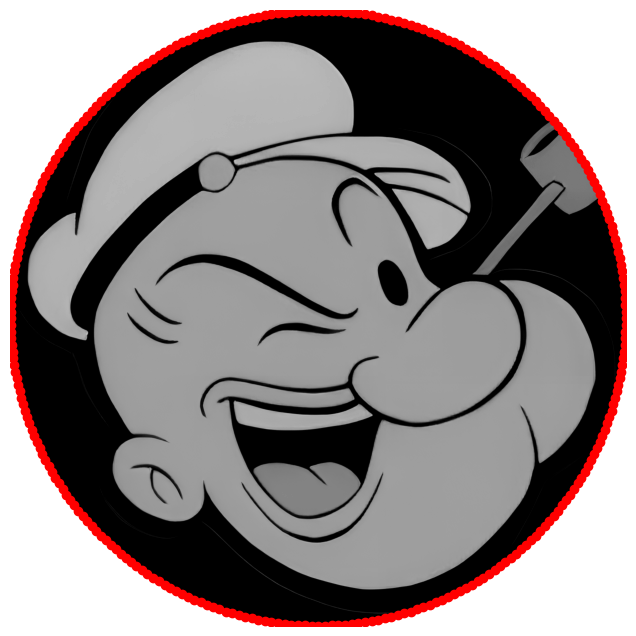

In [200]:
# Preprocess image
img, center, radius = preprocess_image(img_path)

# Create anchors
anchors = create_anchors(center, radius, num_anchors)

mask = create_circle_mask(center, radius, img.shape)

plt.figure(figsize=(8, 8))  
plt.imshow(img.T, cmap='gray_r')
anchors_x, anchors_y = zip(*anchors)
plt.scatter(anchors_x, anchors_y, color='red')
plt.axis('off')
plt.show()

In [201]:
def draw_line(p0: tuple, p1: tuple, multiplier: float, mask):
    """Creates a dictionary of coordinates and their darkness values of a line between two points. Uses Xiaolin Wu’s anti-aliasing algorithm
    Args: 
        p0: The first coordinate for the line
        p1: The second cordinate for the line
        multiplier: The darkness value that gets multiplied by each pixel
        mask: The boolean mask for a circle
    Returns:
        A dictionary of each pixel in the line and their darkness value
    """
    x0, y0 = p0
    x1, y1 = p1
    img = {}
    steep = abs(y1 - y0) > abs(x1 - x0)
    if steep:
        x0, y0 = y0, x0
        x1, y1 = y1, x1

    if x0 > x1:
        x0, x1 = x1, x0
        y0, y1 = y1, y0

    dx = x1 - x0
    dy = y1 - y0
    gradient = dy / dx if dx != 0 else 1

    # handle first endpoint (pixel) placement
    xend = round(x0)
    yend = y0 + gradient * (xend - x0)
    xgap = 1 - ((x0 + 0.5) % 1)
    xpxl1 = xend
    ypxl1 = int(yend)
    if steep:
        try: #TODO try and see if checking if the pixel is in the circle using an if statement is faster than try / except
            if mask[ypxl1, xpxl1]: img[(ypxl1, xpxl1)] = xgap * (1 - (yend % 1)) * multiplier
        except IndexError:
            pass
        try:
            if mask[ypxl1+1, xpxl1]: img[(ypxl1+1, xpxl1)] = xgap * (yend % 1) * multiplier
        except IndexError:
            pass
    else:
        try:
            if mask[xpxl1, ypxl1]: img[(xpxl1, ypxl1)] = xgap * (1 - (yend % 1)) * multiplier
        except IndexError:
            pass
        try:
            if mask[xpxl1, ypxl1+1]: img[(xpxl1, ypxl1+1)] = xgap * (yend % 1) * multiplier
        except IndexError:
            pass
    intery = yend + gradient

    # handle second endpoint
    xend = round(x1)
    yend = y1 + gradient * (xend - x1)
    xgap = (x1 + 0.5) % 1
    xpxl2 = xend
    ypxl2 = int(yend)
    if steep:
        try:
            if mask[ypxl2, xpxl2]: img[(ypxl2, xpxl2)] = xgap * (1 - (yend % 1)) * multiplier
        except IndexError:
            pass
        try:
            if mask[ypxl2+1, xpxl2]: img[(ypxl2+1, xpxl2)] = xgap * (yend % 1) * multiplier
        except IndexError:
            pass
    else:
        try:
            if mask[xpxl2, ypxl2]: img[(xpxl2, ypxl2)] = xgap * (1 - (yend % 1)) * multiplier
        except IndexError:
            pass
        try:
            if mask[xpxl2, ypxl2+1]: img[(xpxl2, ypxl2+1)] = xgap * (yend % 1) * multiplier
        except IndexError:
            pass

    # main loop
    for x in range(int(xpxl1 + 1), int(xpxl2)):
        if steep:
            try:
                if mask[int(intery), x]: img[(int(intery), x)] = (1 - (intery % 1)) * multiplier
            except IndexError:
                pass
            try:
                if mask[int(intery)+1, x]: img[(int(intery)+1, x)] = (intery % 1) * multiplier
            except IndexError:
                pass
        else:
            try:
                if mask[x, int(intery)]: img[(x, int(intery))] = (1 - (intery % 1)) * multiplier
            except IndexError:
                pass
            try:
                if mask[x, int(intery)+1]: img[(x, int(intery)+1)] = (intery % 1) * multiplier
            except IndexError:
                pass
        intery += gradient
    return img

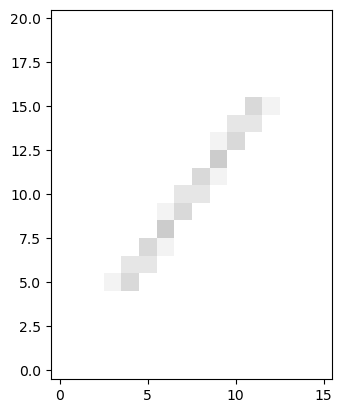

In [202]:
def test_line(p1, p2):
    # Get the maximum coordinates to determine image size
    max_x = max(p1[0], p2[0])
    max_y = max(p1[1], p2[1])
    
    # Create an empty image
    temp_img = np.zeros((max_x + 1, max_y + 1))
    
    temp_mask = create_circle_mask((int(temp_img.shape[0]/2), int(temp_img.shape[1]/2)), min([int(temp_img.shape[0]/2), int(temp_img.shape[1]/2)]), img.shape)
    line_pixels = draw_line(p1, p2, line_darkness, temp_mask)

    # Set the pixel values
    for pixel, value in line_pixels.items():
        temp_img[pixel] = value

    # Display the image
    plt.imshow(temp_img, cmap='gray_r', origin='lower', vmin=0, vmax=1)
    plt.show()

# Test the function
p1 = (0, 0)
p2 = (20, 15)
test_line(p1, p2)

In [203]:
def generate_all_lines(start_anchor):
    """Generates all lines between one anchor and all other anchors. Only used for benchmarking"""
    line_list = {}
    for end_anchor in anchors:
        if end_anchor is not start_anchor:
            both_anchors = tuple(sorted((start_anchor, end_anchor)))
            if both_anchors not in line_list:
                line = draw_line(both_anchors[0], both_anchors[1], line_darkness, mask)
                line_list[both_anchors] = line
    return line_list

In [204]:
#benchmark
start_time = time.perf_counter()
benchmark = generate_all_lines(anchors[0])
print(f"Starting Benchmark for ")
run_time = (time.perf_counter() - start_time)*1000
estimated_total_time = run_time*(comb(num_anchors, 2)/num_anchors)
print(f"Done! Generated {len(benchmark)} anchor lines on a canvas of size of {radius*2} in {round(run_time, 1)} milliseconds. Estimated time for generating line dict about {round(estimated_total_time/1000, 1)} seconds")

Starting Benchmark for 
Done! Generated 287 anchor lines on a canvas of size of 1232 in 1224.5 milliseconds. Estimated time for generating line dict about 175.7 seconds


In [205]:
def is_within_range(arr, idx1, idx2, x):
    # Calculate the distance between indices in both directions considering wrapped boundaries
    forward_distance = (idx2 - idx1) % len(arr)
    backward_distance = (idx1 - idx2) % len(arr)

    # Check if either forward or backward distance is less than or equal to x
    return forward_distance <= x or backward_distance <= x or idx1 == idx2

In [206]:
def make_line_dict(anchors):
    """Makes a dictionary of every pixel and its darkness value for each line for every possible combination of anchors"""
    line_dict = {}
    for start_index, start_anchor in enumerate(tqdm(anchors, desc="Creating Lines")):
        for end_index, end_anchor in enumerate(anchors):
            if is_within_range(anchors, start_index, end_index, 5): continue #You cant make a line between two of the same anchors
            both_anchors = tuple(sorted((start_anchor, end_anchor))) #Sorts the indices for the lines.
            if both_anchors not in line_dict: #Makes sure that the anchors aren't already in the dictionary, only in a different order. This makes the number of lines needed n choose 2.
                line = draw_line(both_anchors[0], both_anchors[1], line_darkness, mask) #Draws the line
                line_dict[both_anchors] = line
    return line_dict

In [207]:
line_dict = make_line_dict(anchors=anchors)

Creating Lines:   0%|          | 0/288 [00:00<?, ?it/s]

In [208]:
def difference(pixel1, pixel2):
    """Calculate the absolute difference between two pixel values."""
    return abs(pixel1 - pixel2)

In [209]:
def create_string_art_dict(image, center, radius):
    """Creates a dictionary of pixels inside of the circle, and sets them equal to 0. This will be updated for every added string."""
    height, width = image.shape
    string_art_dict = {}

    for y in range(height):
        for x in range(width):
            if mask[x, y]:
                string_art_dict[(x, y)] = 0
                
    return string_art_dict

In [210]:
def create_difference_dict(image, center, radius):
    """Creates a dictionary of pixels inside of the circle, and sets them equal to the values of the original image. This difference dictionary is used to save the differences between the string_art_dict and the  original image"""
    height, width = image.shape
    difference_dict = {}

    for y in range(height):
        for x in range(width):
            if mask[x, y]:
                difference_dict[(x, y)] = difference(0, image[x, y])
                
    return difference_dict

In [211]:
difference_dict = create_difference_dict(img, center, radius)
string_art_dict = create_string_art_dict(img, center, radius)

In [212]:
def get_initial_loss():
    loss = sum(difference_dict.values())
    return loss

In [213]:
def find_new_loss(loss, string_line):
    """Finds the loss of a single string"""
    for pixel, value in string_line.items(): #Checks each pixel-value pair in the string 
        total_value = min(1, string_art_dict[pixel] + value)
        loss += difference(img[pixel], total_value) - difference_dict[pixel] #Finds the total loss of the image by updating it dynamicaly using only the changed pixels. This is a big improvement from before when it had to find the sum of every difference pixel for iteration
    return loss
    

In [214]:
def find_best_line(loss, start_anchor, anchor_list):
    """Starts at a specified anchor and find the loss for every string leading to every other anchor, updating the best loss whenever a better one is found"""
    best_loss = np.inf #TODO set this to the starting loss and make the algorithm terminate when there isn't a possible improvement
    best_anchors = None #Also saves the set of anchors
    best_end_anchor = None
    for end_anchor in anchors:
        if start_anchor is not end_anchor: #You can't have a string that goes to the same anchor as where it came from
            both_anchors = tuple(sorted((start_anchor, end_anchor))) #Makes sure to get the right order for the indices, set in make_line_dict().
            if both_anchors not in line_dict: continue
            temp_loss = find_new_loss(loss, line_dict[both_anchors]) #Finds the loss of that string
            if(temp_loss < best_loss): #Check if the loss is better
                best_loss = temp_loss
                best_anchors = both_anchors
                best_end_anchor = end_anchor
    #if len(anchor_list) >= 2:
        #print(f"Start Anchor: {start_anchor} | End Anchor: {best_end_anchor} | Previous Anchor: {anchor_list[len(anchor_list)-2]}")
    return best_loss, best_anchors, best_end_anchor

In [215]:
def update_with_best_line(best_anchors, loss, difference_dict, string_art_dict):
    """Updates the overall loss value, string_art_dict pixels, and difference_dict pixels after finding the best line"""
    best_line = draw_line(best_anchors[0], best_anchors[1], line_darkness, mask) #Redraws the line
    for pixel, value in best_line.items():
        new_value = min(1, string_art_dict[pixel] + value) #Adds the string value to the old value, with a max darkness of 1
        string_art_dict[pixel] = new_value 
        difference_dict[pixel] = difference(img[pixel], new_value) #Sets the difference_dict pixel value to the new difference
    loss = sum(difference_dict.values()) #Updates the loss
    return loss, string_art_dict, difference_dict

In [216]:
loss = get_initial_loss()

In [217]:
current_anchor = anchors[0]
anchor_list = []
for i in tqdm(range(4000), desc="Drawing Lines"):
    best_loss, best_anchors, current_anchor = find_best_line(loss, current_anchor, anchor_list)
    #print(best_loss, best_anchors)
    loss, string_art_dict, difference_dict = update_with_best_line(best_anchors, loss, difference_dict, string_art_dict)
    anchor_list.append(current_anchor)

Drawing Lines:   0%|          | 0/4000 [00:00<?, ?it/s]

In [223]:
print(anchor_list)

[(1, 629), (1231, 603), (1, 616), (1231, 629), (1, 629), (1230, 643), (1, 603), (1231, 616), (1, 616), (1230, 576), (1, 629), (1230, 656), (1, 616), (1230, 589), (1, 603), (1230, 576), (2, 589), (1231, 603), (2, 656), (1231, 629), (2, 589), (1231, 616), (2, 576), (1230, 589), (3, 562), (1231, 603), (5, 683), (1231, 629), (3, 670), (1230, 656), (2, 643), (1229, 670), (2, 656), (1226, 696), (2, 643), (1222, 723), (2, 656), (1219, 736), (3, 670), (1227, 683), (6, 696), (1226, 696), (3, 670), (1216, 749), (5, 683), (1230, 656), (10, 723), (1226, 696), (8, 710), (1231, 629), (10, 509), (1230, 576), (2, 576), (1227, 549), (3, 562), (1229, 562), (2, 589), (1224, 522), (3, 562), (1222, 509), (5, 549), (1230, 589), (10, 509), (1227, 549), (8, 522), (1230, 576), (13, 496), (1227, 549), (16, 483), (1229, 562), (5, 549), (1226, 536), (13, 496), (1222, 509), (5, 683), (1229, 670), (1, 616), (1230, 643), (3, 562), (1210, 457), (5, 549), (1206, 444), (2, 656), (1230, 643), (26, 788), (1227, 683), (8,

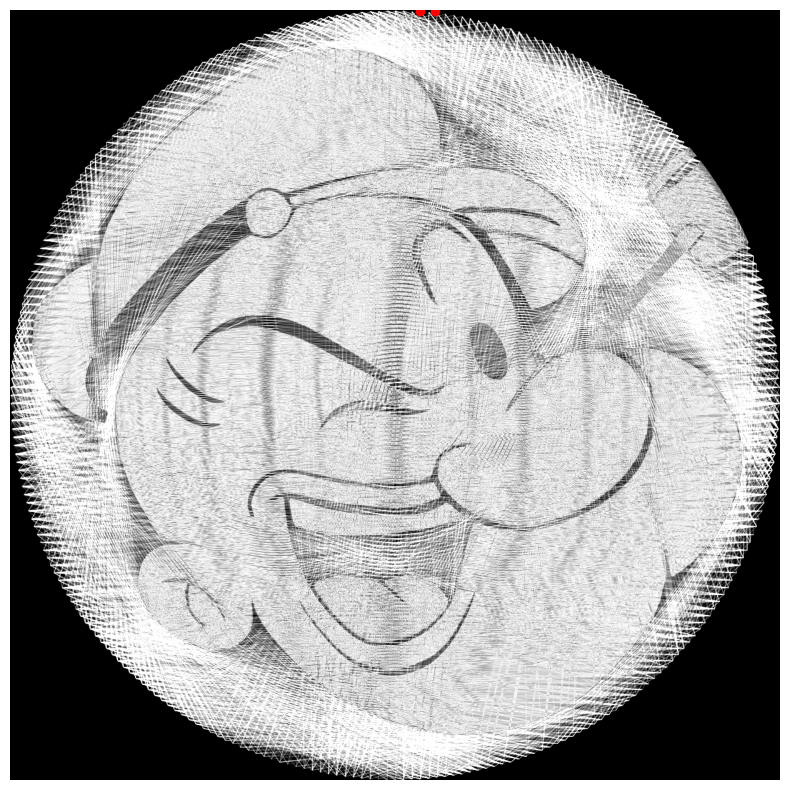

In [224]:
# Create a blank white canvas
canvas = np.ones((radius*2, radius*2))

# Draw the circle using the string_art_dict
for (x, y), value in difference_dict.items():
    canvas[x, y] = value

# Show the canvas
plt.figure(figsize=(10, 10))
plt.imshow(canvas.T, cmap='gray_r', vmin=0, vmax=1)
plt.scatter(656, 1, color='red')
plt.scatter(680, 1, color='red')
plt.axis('off')
plt.show()

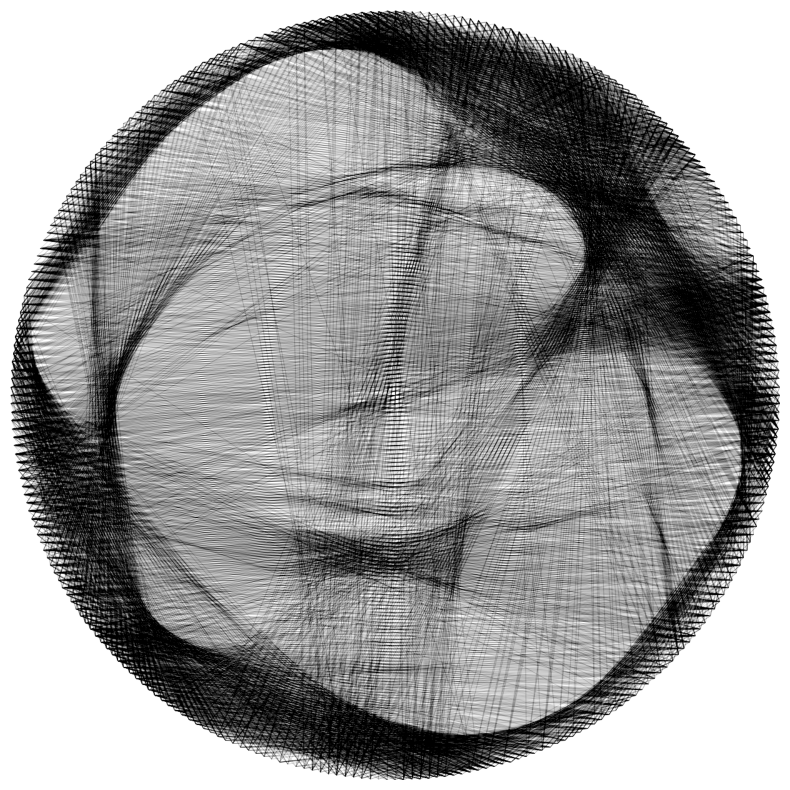

In [228]:
# Create a blank white canvas
canvas = np.zeros((radius*2, radius*2))

# Draw the circle using the string_art_dict
for (x, y), value in string_art_dict.items():
    canvas[x, y] = value

# Show the canvas
plt.figure(figsize=(10, 10))
plt.imshow(canvas.T, cmap='gray_r', vmin=0, vmax=1)
plt.axis('off')
plt.show()